# Explore the data

The intention of this notebook is to explore the data and try out the methods of the developed library.

## Imports and basic definitions

In [1]:
import os

from rfa import *

NA = NetworkAnalyzer
import matplotlib.pyplot as plt

output_dir: str = "output/"
os.makedirs(output_dir, exist_ok=True)

reader = WikiDataReader("data/original.txt")

## Full Graph

In [2]:
graph_maker = WikiDataGraphMaker()
graph_maker.data = reader.data
g = graph_maker.make()

In [3]:

# basic statistics
print("number_of_nodes = ", NA.number_of_nodes(g))
print("number_of_edges = ", NA.number_of_edges(g))
print(
    "weakely_connected_components = ",
    NA.weakely_connected_components(g)["number_of_connected_componets"],
)
print("has cycle = ", NA.has_cycle(g))

number_of_nodes =  11256
number_of_edges =  184546
weakely_connected_components =  1
has cycle =  True


## Gephi

Export full graph to Gephi (it takes some time...)

In [4]:
gephi_file: str = os.path.join(output_dir, "gephi.gexf")
NA.export_to_gephi(g, gephi_file)
print(f"Gephi file '{gephi_file} written")

Gephi file 'output/gephi.gexf written


## Plot the number of votes per year

The number of votes is the 

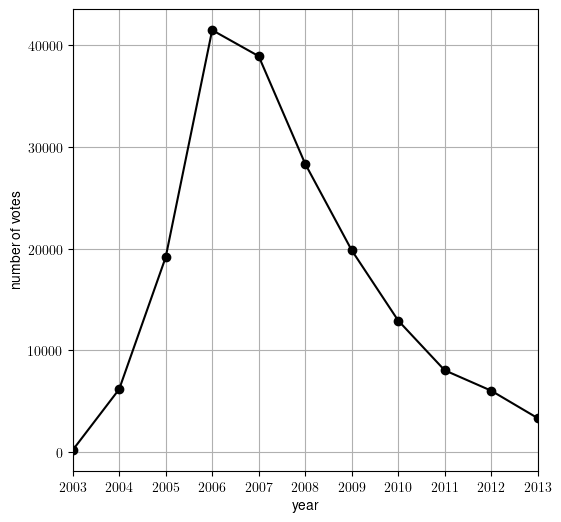

In [5]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
gpy = GraphPerYear(reader.data)
gpy.plot(
    ax,
    lambda g: g.number_of_edges(),
    y_label="number of votes",
)
fig.savefig(os.path.join(output_dir, "number_of_votes_per_year.png"))
plt.close(fig)
fig

## Quartiles

Plot the quartiles per year. We want to see how people's behavior changed over time.

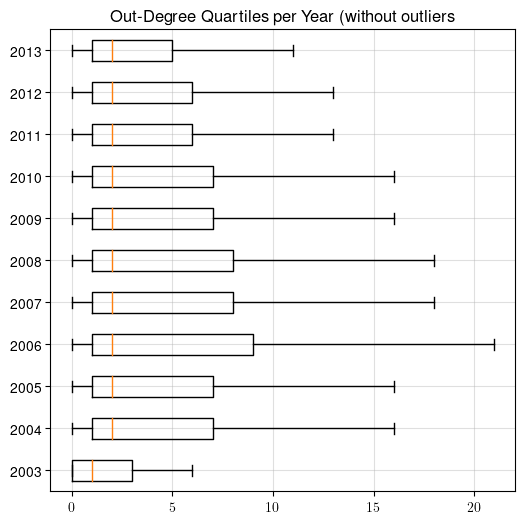

In [6]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
gpy = GraphPerYear(reader.data)
gpy.plot_quartiles(
    ax,
    degree_type="out",
)
fig.savefig(os.path.join(output_dir, "quartiles_out.png"))
plt.close(fig)
fig

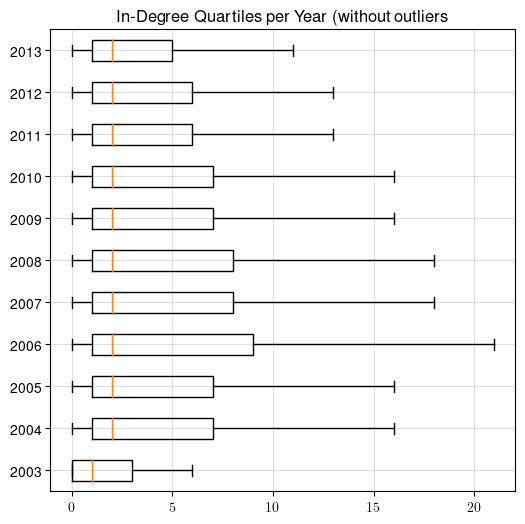

In [7]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
gpy = GraphPerYear(reader.data)
gpy.plot_quartiles(
    ax,
    degree_type="in",
)
fig.savefig(os.path.join(output_dir, "quartiles_in.png"))
plt.close(fig)
fig

## Cummulative Degree Distribution

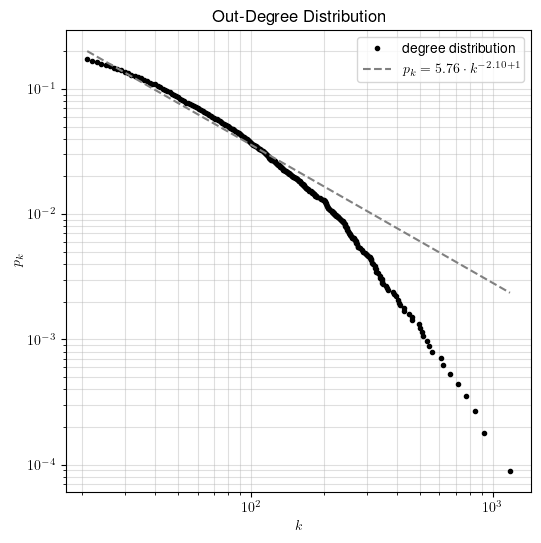

In [8]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
cdd = CummulativeDegreeDistribution(g)
cdd.plot(ax)
fig.savefig(os.path.join(output_dir, cdd.file_name))
plt.close(fig)
fig